# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [65]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from multi_ouputs import build_XY, ICM, LCM, MultiMarginal
from mo import MultiOutputMarginal

In [66]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [67]:
train_x = np.linspace(0, 1, 50)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [68]:
train_x.shape, train_y.shape

((50,), (50, 3))

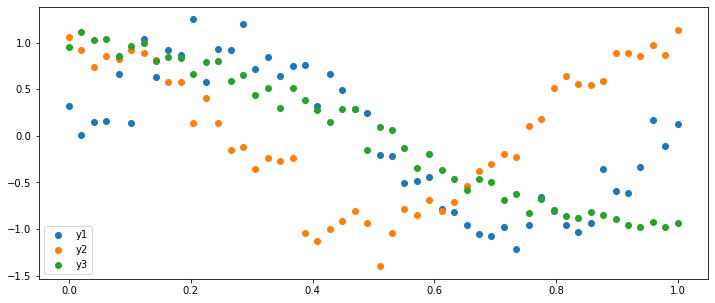

In [69]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [70]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [71]:
np.vstack([train_y[:,0], train_y[:,1], train_y[:,2]]).shape

(3, 50)

In [72]:
x = train_x.reshape(-1,1)
X, Y, _ = build_XY([x,x,x], 
                   [train_y[:,0].reshape(-1,1), 
                    train_y[:,1].reshape(-1,1), 
                    train_y[:,2].reshape(-1,1)])
x.shape, X.shape, Y.shape

((50, 1), (150, 2), (150, 1))

In [73]:
n_points = 200
x_new = np.linspace(-0.5, 1.5, n_points)[:, None]
X_new, _, _ = build_XY([x_new, x_new, x_new])

In [74]:
X_new.shape

(600, 2)

### ICM: one kernel

In [78]:
import aesara.tensor as at

In [79]:
type(ell), type(cov)

(aesara.tensor.var.TensorVariable, pymc.gp.cov.Prod)

In [80]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    W = np.random.rand(2,2)
    B = at.dot(W, W.T)
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal(means=0, kernels=[cov], input_dim=2, active_dims=[1], num_outputs=3, W=W, B=B)
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)


In [81]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_0_W, ICM_0_kappa]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 168 seconds.


CPU times: user 3min 20s, sys: 7min 17s, total: 10min 37s
Wall time: 2min 55s


In [82]:
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


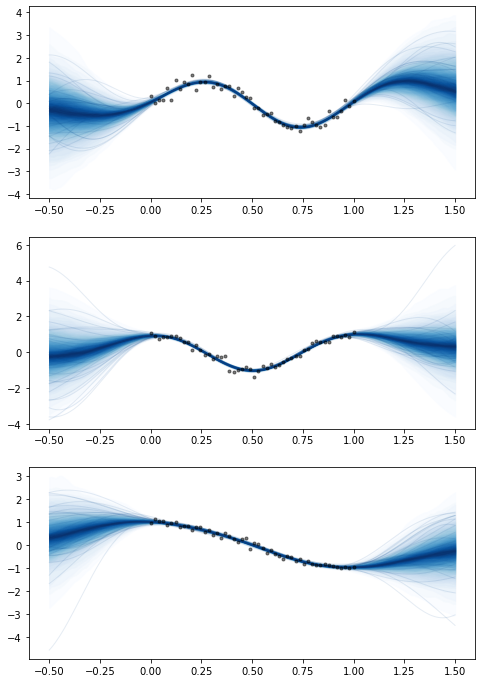

In [83]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [84]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_0_W[0, 0]",-0.038,2.527,-4.805,4.426,0.127,0.095,399.0,381.0,NaN
"ICM_0_W[1, 0]",0.174,2.638,-4.480,5.101,0.160,0.113,279.0,278.0,NaN
"ICM_0_W[2, 0]",0.015,1.614,-3.104,3.076,0.073,0.069,506.0,297.0,NaN
ell,0.325,0.037,0.259,0.389,0.002,0.001,389.0,416.0,NaN
eta,0.513,0.181,0.240,0.856,0.010,0.008,378.0,350.0,NaN
sigma,0.156,0.010,0.139,0.175,0.000,0.000,583.0,357.0,NaN
ICM_0_kappa[0],5.459,2.231,1.273,9.270,0.121,0.086,314.0,277.0,NaN
ICM_0_kappa[1],5.320,2.268,1.711,9.082,0.087,0.065,529.0,266.0,NaN
ICM_0_kappa[2],4.062,1.799,0.823,7.325,0.076,0.056,543.0,397.0,NaN


### LCM: two or more kernels

In [44]:
# OPTION 2
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=2, beta=0.5, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in enumerate(kernels)]
    
    # Define a Multi-output GP using `lcm` or `icm` coregion
    mogp = MultiOutputMarginal(means=0, kernels=cov_list, input_dim=2, active_dims=[1], num_outputs=3)    
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)    

In [45]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_0_W, ICM_0_kappa, ICM_1_W, ICM_1_kappa]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 54 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6866, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 2min 22s, sys: 4min 54s, total: 7min 17s
Wall time: 1min 1s


In [46]:
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

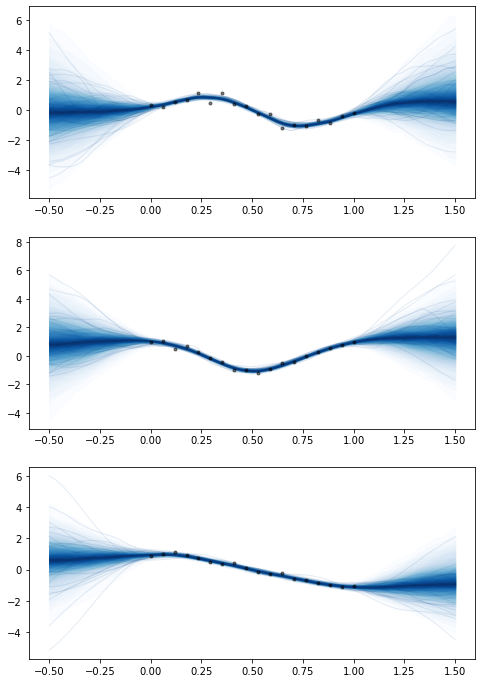

In [47]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [48]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_0_W[0, 0]",0.357,4.336,-8.582,8.155,0.283,0.207,223.0,250.0,NaN
"ICM_0_W[1, 0]",-0.238,3.727,-7.754,6.855,0.199,0.229,301.0,203.0,NaN
"ICM_0_W[2, 0]",-0.184,3.676,-7.182,6.619,0.239,0.374,237.0,207.0,NaN
"ICM_1_W[0, 0]",0.313,3.845,-6.921,6.680,0.358,0.328,122.0,120.0,NaN
"ICM_1_W[1, 0]",0.042,2.868,-6.252,4.737,0.220,0.199,179.0,119.0,NaN
"ICM_1_W[2, 0]",-0.002,1.949,-3.381,4.080,0.174,0.190,132.0,121.0,NaN
ell[0],2.996,3.240,0.210,8.661,1.551,1.180,3.0,137.0,NaN
ell[1],2.561,2.504,0.324,7.794,1.376,1.074,4.0,58.0,NaN
eta[0],0.752,0.768,0.050,1.891,0.108,0.077,151.0,245.0,NaN
eta[1],1.064,0.941,0.076,2.495,0.153,0.109,11.0,162.0,NaN


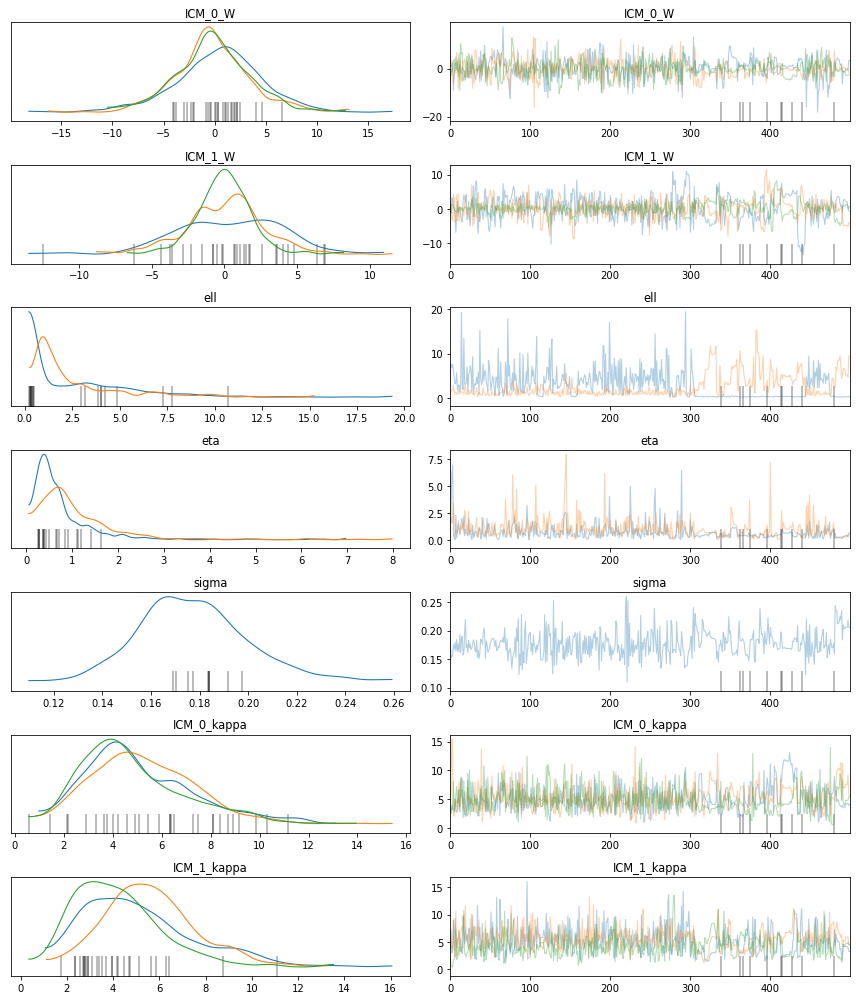

In [49]:
az.plot_trace(gp_trace);
plt.tight_layout()